In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  1.13 ; cuda:  cu117
detectron2: 0.6


In [2]:
import os
import sys
import logging
import argparse
os.environ["DATASET"] = "../datasets"

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from pprint import pprint
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import warnings
warnings.filterwarnings(action='ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from xdecoder.BaseModel import BaseModel
from xdecoder import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Mygit/X-Decoder


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
import yaml
import json
import argparse
import logging
import os

def load_vcoco_parser():
    parser = argparse.ArgumentParser(description='Pretrain or fine-tune models for NLP tasks.')
    parser.add_argument('--command', default="evaluate", help='Command: train/evaluate/train-and-evaluate')
    parser.add_argument('--conf_files', nargs='+', help='Path(s) to the config file(s).')
    parser.add_argument('--user_dir', help='Path to the user defined module for tasks (models, criteria), optimizers, and lr schedulers.')
    parser.add_argument('--config_overrides', nargs='*', help='Override parameters on config with a json style string, e.g. {"<PARAM_NAME_1>": <PARAM_VALUE_1>, "<PARAM_GROUP_2>.<PARAM_SUBGROUP_2>.<PARAM_2>": <PARAM_VALUE_2>}. A key with "." updates the object in the corresponding nested dict. Remember to escape " in command line.')
    parser.add_argument('--overrides', help='arguments that used to override the config file in cmdline', nargs=argparse.REMAINDER)
    cmdline_args = parser.parse_args('')
    return cmdline_args

def load_vcoco_opt_command(cmdline_args):
    opt = load_opt_from_config_files(cmdline_args.conf_files)
    opt["base_path"] = "../"

    keys = [cmdline_args.overrides[idx*2] for idx in range(len(cmdline_args.overrides)//2)]
    vals = [cmdline_args.overrides[idx*2+1] for idx in range(len(cmdline_args.overrides)//2)]
    vals = [val.replace('false', '').replace('False','') if len(val.replace(' ', '')) == 5 else val for val in vals]
    types = []
    for key in keys:
        key = key.split('.')
        ele = opt.copy()
        while len(key) > 0:
            ele = ele[key.pop(0)]
        types.append(type(ele))

    config_dict = {x:z(y) for x,y,z in zip(keys, vals, types)}

    load_config_dict_to_opt(opt, config_dict)
    for key, val in cmdline_args.__dict__.items():
        if val is not None:
            opt[key] = val

    return opt

cmdline_args = load_vcoco_parser()
cmdline_args.conf_files = [os.path.join(home_dir, "configs/xdecoder/segvlp_focalt_lang.yaml")]
# cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides = ['DONT_LOAD_MODEL', 'false', 'PYLEARN_MODEL', '../data/output/test/00062100/default/raw_model_states.pt'] 


opt = load_vcoco_opt_command(cmdline_args)
opt = init_distributed(opt)

In [4]:
from datasets.build import build_train_dataloader
train_data_loader = build_train_dataloader(opt)
dataset_names = opt['DATASETS']['TRAIN']
print(len(train_data_loader))

INFO:datasets.dataset_mappers.coco_panoptic_new_baseline_dataset_mapper:[COCOPanopticNewBaselineDatasetMapper] Full TransformGens used in training: [RandomFlip(), ResizeScale(min_scale=0.1, max_scale=2.0, target_height=1024, target_width=1024), FixedSizeCrop(crop_size=(1024, 1024))]
INFO:datasets.build:Using training sampler TrainingSampler
INFO:detectron2.data.common:Serializing 112580 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 204.50 MiB


56290


[[ 504.  537.  531.  565.]
 [ 239.  554.  300.  601.]
 [   0.    0.    0.    0.]
 [ 768.  664.  829.  692.]
 [ 686.  576.  768.  675.]
 [ 410.  587.  429.  631.]
 [ 126.  623.  154.  678.]
 [   0.    0.    0.    0.]
 [ 818.  667.  867.  733.]
 [ 531.  537.  581.  587.]
 [ 189.  584.  231.  623.]
 [ 666.  642.  730.  705.]
 [ 429.  595.  498.  653.]
 [   0.  366. 1024.  758.]
 [   0.  314.  964.  992.]
 [  76.  827.  134.  854.]
 [ 523.  733.  628.  843.]
 [   0.    0. 1024.  435.]
 [   0.  314. 1016.  818.]]


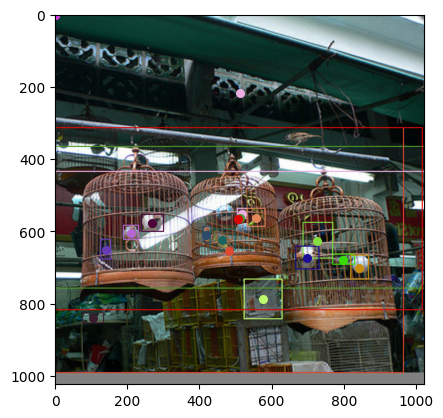

[[ 72.  45.  79.  59.]
 [ 23.  33.  68.  72.]
 [ 15.  60.  23.  70.]
 [ 99.  65. 106.  72.]
 [ 73.  60.  95.  75.]
 [  0.   0.  46.  33.]
 [  6.  53. 109.  86.]
 [  0.  67.  67.  86.]
 [ 37.  13. 112.  81.]
 [  0.   0. 115.  69.]]


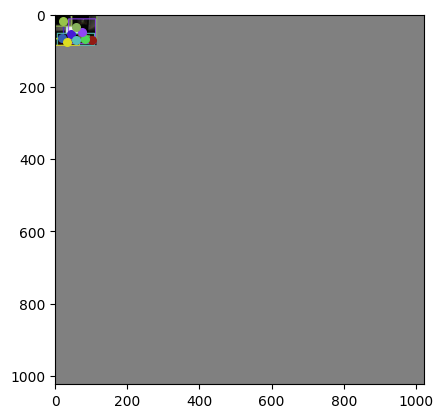

[[   0.    0.    0.    0.]
 [ 352.  201.  378.  281.]
 [ 189.  246.  274.  492.]
 [ 809.  554.  881.  709.]
 [  98.  236.  218.  580.]
 [ 875.  562.  985.  765.]
 [ 272.  190.  376.  564.]
 [  12.  313.  127.  460.]
 [ 560.  246.  720.  431.]
 [ 710.    0. 1024.  602.]
 [  95.  476.  432.  866.]
 [   0.    0.   58.   76.]
 [ 223.  129.  413.  206.]
 [ 253.  118.  400.  174.]
 [  66.  140.  298.  257.]
 [   0.  271. 1024. 1024.]
 [   0.   60.   95.  166.]
 [   0.  495.  742. 1024.]
 [   0.    0.  867.  377.]]


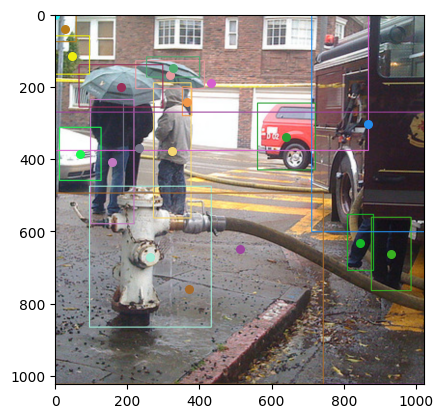

[[107.  47. 118.  55.]
 [ 98.  47. 102.  57.]
 [192.  86. 199.  99.]
 [124.  51. 126.  55.]
 [184.  87. 190.  99.]
 [131.  53. 134.  56.]
 [ 48.  98.  56. 110.]
 [ 55.  34. 157. 117.]
 [181.  91. 203.  98.]
 [155.  94. 169. 108.]
 [  0.  47.  59. 108.]
 [  0.  91. 223. 149.]
 [  0.  45.  83.  96.]
 [ 98.  11. 183.  61.]
 [  0.   0. 223.  64.]
 [  6.  77.  48. 101.]
 [ 27.  92.  37.  98.]
 [144.  28. 223. 101.]]


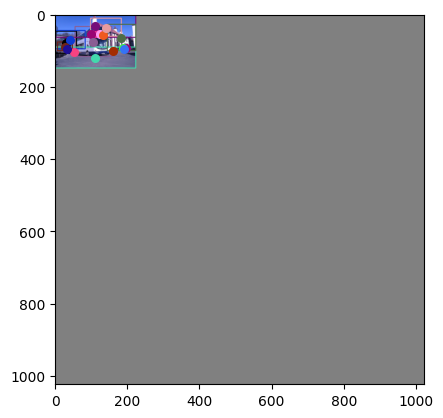

[[ 283.  108.  646.  625.]
 [ 243.  617.  678.  666.]
 [   0.    0. 1024.  807.]]


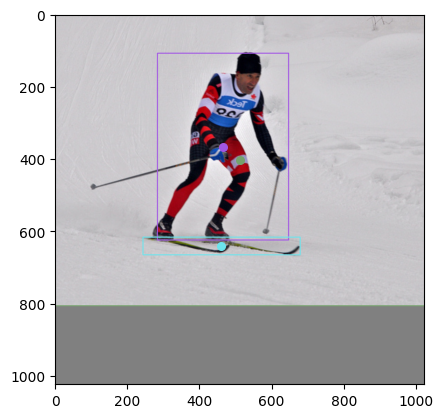

[[507. 332. 531. 378.]
 [368. 292. 400. 363.]
 [395. 291. 505. 378.]
 [132. 187. 369. 649.]
 [808. 113. 980. 727.]
 [358. 305. 830. 527.]
 [458. 167. 844. 387.]
 [338.   0. 574.  37.]
 [ 21.   0. 980. 735.]
 [  0. 643. 600. 735.]
 [  0.   0. 467. 698.]]


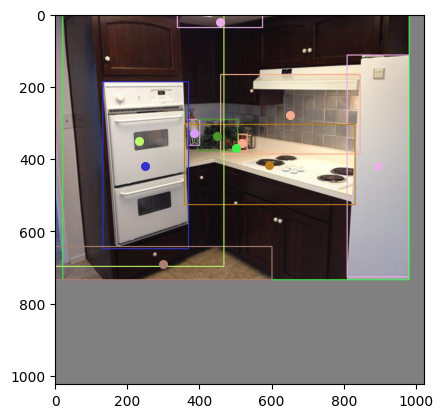

In [5]:
import cv2, random
from matplotlib import pyplot as plt
def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r

with torch.no_grad():
    for idx, batches in enumerate(train_data_loader):
        if idx > 2:
            break
        for key, batch in batches.items():
            for idx, batch_per_image in enumerate(batch):
                obj_boxes = batch_per_image['instances'].gt_boxes.tensor
                target_img = batch_per_image["image"]
                img = target_img.permute(1, 2, 0).detach().cpu().numpy()
                obj_boxes = obj_boxes.cpu().numpy()

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                # targets_per_image = batch_per_image["instances"].to(opt.device)
                print(obj_boxes)
                for box in obj_boxes:
                    color = random_color()
                    box = box.astype(int)
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    # plt.text(
                    #     x + 5,
                    #     y + 5,
                    #     label,
                    #     fontsize=10,
                    #     bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                    #     )
                
                plt.imshow(img)
                plt.show()